In [1]:
import pandas as pd
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.metrics import roc_curve, auc

# Problem statement
This project focuses on loan default prediction in credit applications. The primary goal is to develop a predictive model capable of classifying whether a loan applicant is likely to default or not. Leveraging historical data that includes both approved and defaulted loans, the model aims to identify patterns and relationships within its features.

Ultimately, the project aims illustrate the possibility of optimizing the credit approval process, minimizing the occurrence of loan defaults and fostering more informed and prudent lending practices.

# Data extraction

In [2]:
# Extracting dataset
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# Find duplicate rows
duplicate_rows = df.duplicated().sum()

# Print duplicate rows
print(duplicate_rows)

165


In [4]:
# Drop duplicate rows
df = df.drop_duplicates().copy()

In [5]:
# Create user id column
df['user_id'] = [uuid.uuid4() for _ in range(len(df))]

In [6]:
# Check nulls
df.isnull().sum()/df.shape[0]

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             0.027363
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 0.095478
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
user_id                       0.000000
dtype: float64

# Data exploration

| Feature Name              | Description                 | Nulls    |Data Type  |
|:-------------------------:|:---------------------------:|:--------:|:---------:|
| person_age                | Age                         |0%        |int        |
| person_income             | Annual Income               |0%        |int        |
| person_home_ownership     | Home ownership              |0%        |object     |
| person_emp_length         | Employment length (in years)|2.7%      |float      |
| loan_intent               | Loan intent                 |0%        |object     |
| loan_grade                | Loan grade                  |0%        |object     |
| loan_amnt                 | Loan amount                 |0%        |int        |
| loan_int_rate             | Interest rate               |9.6%      |float      |
| loan_status               | Loan status                 |0%        |int        |
| loan_percent_income       | Percent income              |0%        |float      |
| cb_person_default_on_file | Historical default          |0%        |object     |
| cb_preson_cred_hist_length| Credit history length       |0%        |int        |
| uder_id                   | Unique ID                   |0%        |object     |


In [7]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32416.000000,3.241600e+04,31529.00000,32416.000000,29321.000000,32416.000000,32416.000000,32416.000000
mean,27.747008,6.609164e+04,4.79051,9593.845632,11.017265,0.218688,0.170250,5.811297
std,6.354100,6.201558e+04,4.14549,6322.730241,3.241680,0.413363,0.106812,4.059030
min,20.000000,4.000000e+03,0.00000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.854200e+04,2.00000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.00000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.921800e+04,7.00000,12250.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.00000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [8]:
# Removing values that are apparently a mistake
df = df[(df['person_age'] < 123) & (df['person_emp_length'] < 144)]

In [9]:
df.groupby('loan_status').size()/df.shape[0]#.reset_index(name='count')


loan_status
0    0.784038
1    0.215962
dtype: float64

## Data distribuition

In [10]:
## Separating Variables
def select_variables(df):
        '''
            INPUT:
            df - (pandas dataframe) df as defined at the top of the notebook 

            OUTPUT:
            cat_var - (list) A list of categorical variables
            num_var - (list) A list of numerical variables
        '''
        
        
        target_var = ['loan_status']
        
        num_var = df.select_dtypes(include=['int', 'float']).columns.difference(target_var + ['user_id']).tolist()
        
        cat_var = df.select_dtypes(include=['object']).columns.difference(target_var + ['user_id']).tolist()
        
        print(f"Number of cases: {df.shape[0]}")
        print(f"Variables: {df.shape[1]}")
        print(f'cat_var: {len(cat_var)}')
        print(f'num_var: {len(num_var)}')
        
        return cat_var, num_var, target_var
    
cat_var, num_var, target_var = select_variables(df)

Number of cases: 31524
Variables: 13
cat_var: 4
num_var: 7


**Distribuition will be analyzed considering the target variable**

In [11]:
df_default = df[df['loan_status']==1]
df_paid = df[df['loan_status']==0]

### Numerical features

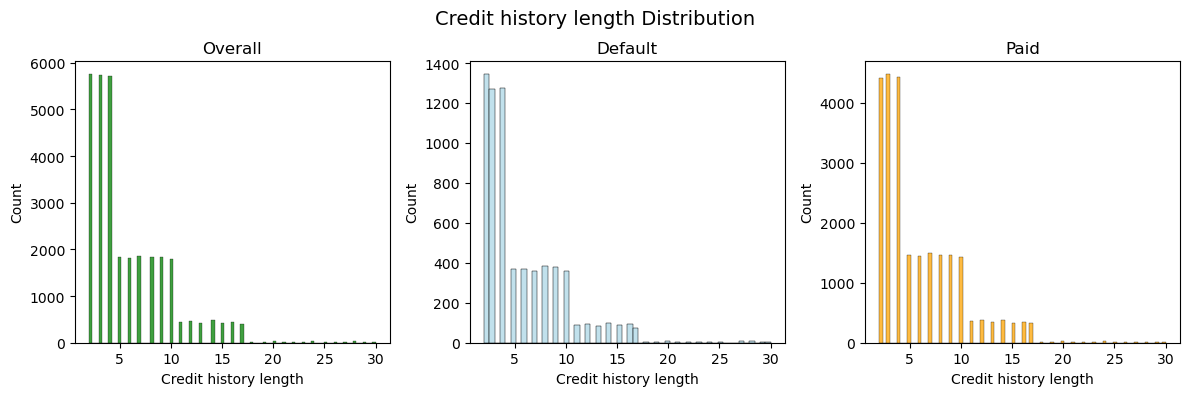

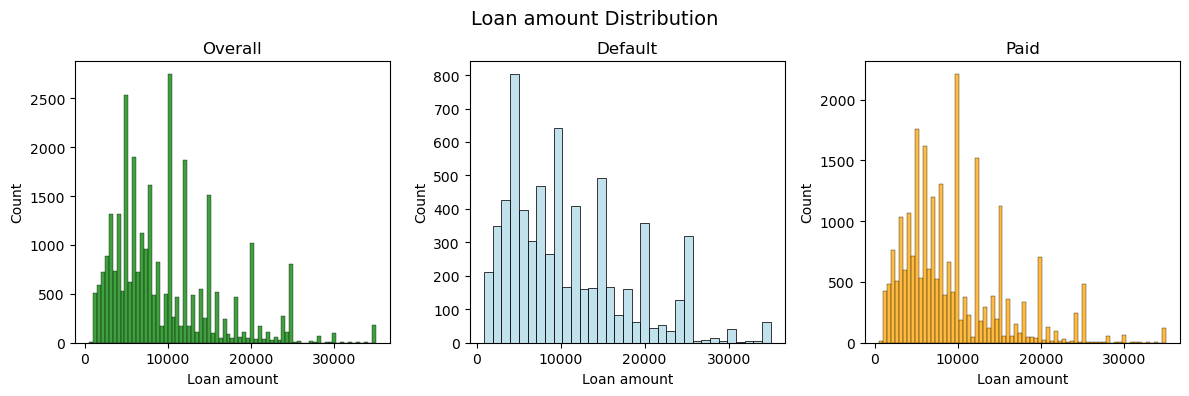

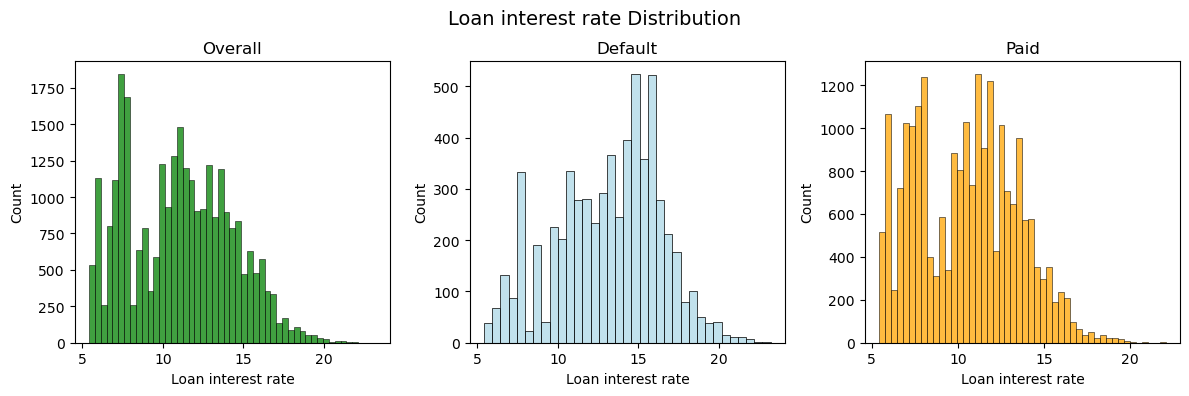

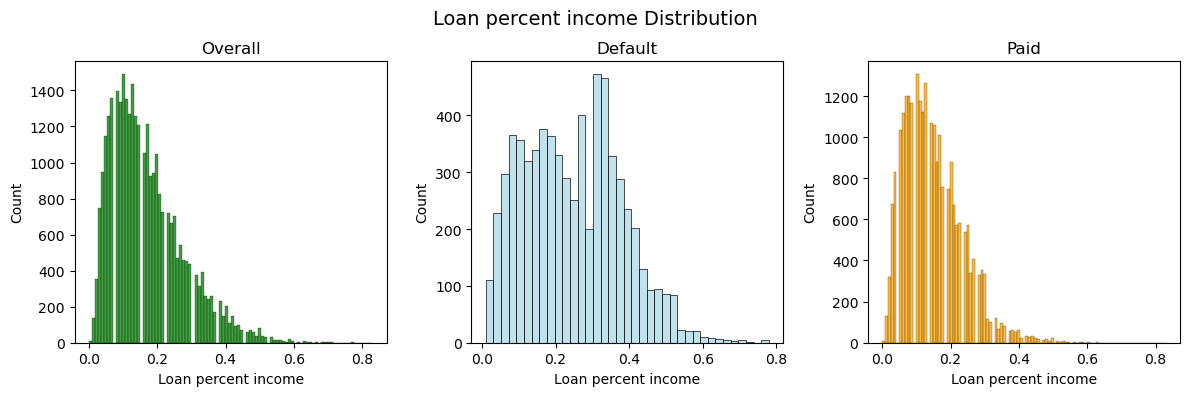

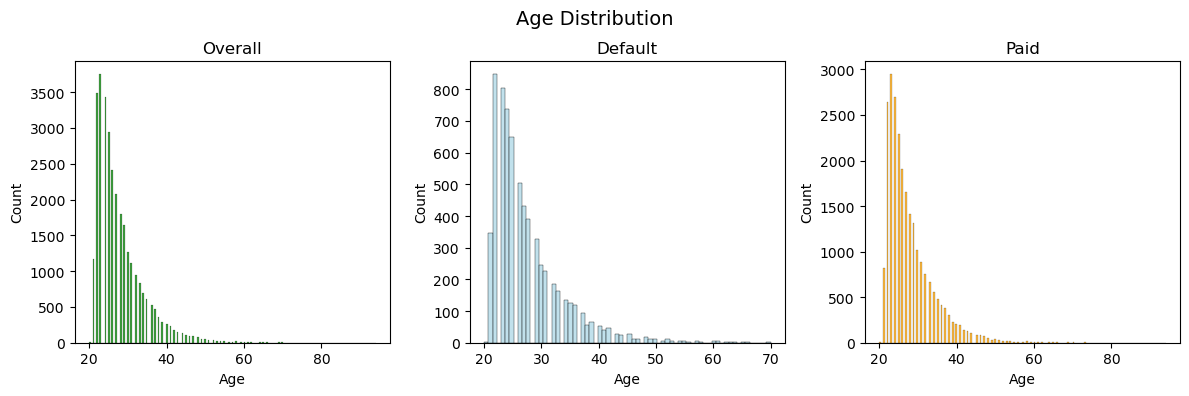

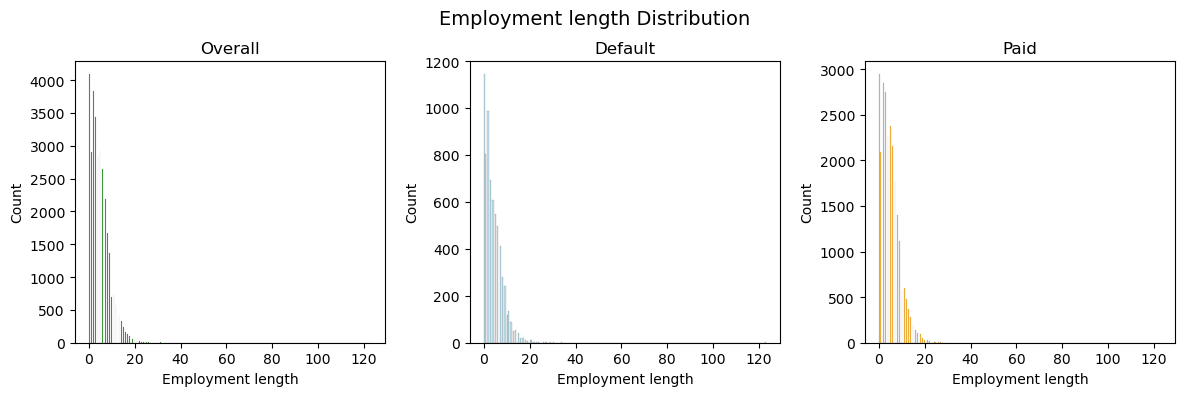

In [ ]:
num_dict = {'cb_person_cred_hist_length': 'Credit history length', 
           'loan_amnt': 'Loan amount', 
           'loan_int_rate': 'Loan interest rate',
           'loan_percent_income':'Loan percent income',
           'person_age':'Age',
           'person_emp_length':'Employment length',
           'person_income':'Income'}

for col in num_var:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Overall distribution
    sns.histplot(data=df, 
                 x=col, 
                 stat='count', 
                 bins='auto', 
                 color='green', 
                 ax=axes[0])
    axes[0].set_title('Overall')
    axes[0].set_xlabel(num_dict[col])
    
    # Default distribution
    sns.histplot(data=df_default, 
                 x=col, 
                 stat='count', 
                 bins='auto', 
                 color='lightblue', 
                 ax=axes[1]) 
    axes[1].set_title('Default')
    axes[1].set_xlabel(num_dict[col])
    
    # Paid distribuition
    sns.histplot(data=df_paid, 
                 x=col, 
                 stat='count', 
                 bins='auto', 
                 color='orange', 
                 ax=axes[2])
    axes[2].set_title('Paid')
    axes[2].set_xlabel(num_dict[col])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(f'{num_dict[col]} Distribution', fontsize=14)
    plt.show()

### Categorical features

In [ ]:
cat_dict = {'cb_person_default_on_file': 'History of default', 
           'loan_grade': 'Loan grade', 
           'loan_intent': 'Loan intent',
           'person_home_ownership':'Home ownership'}

for col in cat_var:
    if col != 'user_id':
    
        fig = figsize=(6, 1)
        palette = {1: 'lightblue', 0: 'orange'}

        sns.countplot(data=df, 
                      x=col, 
                      hue='loan_status', 
                      palette=palette)

        # Add labels and title
        plt.xticks(rotation=45)
        plt.xlabel(f'{cat_dict[col]}')
        plt.ylabel('Count')
        plt.title(f'{cat_dict[col]} distribution')

        # Show the plot
        plt.show()

## Features Correlation

In [ ]:
# Create a subset DataFrame with only the selected numerical variables and the binary variable
subset_df = df[num_var + target_var]

# Compute the correlation using corrwith
correlation_with_binary = subset_df.corrwith(subset_df['loan_status'])

# Reshape the result to a DataFrame for better compatibility with seaborn
correlation_matrix = pd.DataFrame(correlation_with_binary, columns=['Correlation'])

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

# Ensure all labels are visible in the saved figure
plt.tight_layout()

# Add labels and title
plt.ylabel('Numerical Variable')
plt.title('Correlation with Loan Status')

# Data preprocessing

## Spliting train and test data

In [ ]:
# Defining features
X = pd.concat([df[cat_var], df[num_var]], axis=1)

# Keeping y_true
y = df[target_var].values.ravel()

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=20
)

## Pipelines for data transformation

In [ ]:
# Creating pipeline for columns to fill null values with the mean
average_pipeline = Pipeline(
    [
        (
            "imputer", 
            SimpleImputer(strategy="mean")), ("scaler", StandardScaler())
    ]
)

In [ ]:
# Creating pipeline to transform categorical variables
categorical_pipeline = Pipeline(
    [
        (
            "enconder",
            OneHotEncoder(sparse_output=False, drop="first", handle_unknown="ignore"),
        )
    ]
)

In [ ]:
# Transforming the different variables
preprocessor = ColumnTransformer(
    transformers=[
        ("mean", average_pipeline, num_var),
        ("cat", categorical_pipeline, cat_var),
    ]
)

# Model implementation and refinement

In [ ]:
# Create regressors
logreg = LogisticRegression(max_iter=10000)
logreg_l1 = LogisticRegression(penalty="l1", solver="liblinear")

# Create a dictionary of regressors
regressors = {
    "Logistic Regression": logreg,
    "Logistic Regression L1": logreg_l1
}

In [ ]:
# Initialize an empty list to store metrics
metrics_list = []

# Initialize an empty list to store feature coefficients
feature_coefficients_list = []

# Iterate through each regressor
for regressor_name, regressor in regressors.items():
    # Create the pipeline with the regressor
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("regressor", regressor)
        ]
    )

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Make probability predictions
    train_preds = pipeline.predict_proba(X_train)[:, 1]
    test_preds = pipeline.predict_proba(X_test)[:, 1]

    # Compute ROC curve for training set
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_preds)

    # Compute ROC curve for test set
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_preds)

    plt.figure(figsize=(10, 8))

    # Plotting ROC curve for training set
    plt.plot(
        fpr_train, tpr_train, label="Train ROC AUC = %0.2f" % auc(fpr_train, tpr_train)
    )

    # Plotting ROC curve for test set
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC = %0.2f" % auc(fpr_test, tpr_test))

    # Plotting 45 degree line
    plt.plot([0, 1], [0, 1], "r--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title(f"Receiver Operating Characteristic {regressor_name}")
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
    

    # Transform the features using the preprocessor
    X_train_transformed = pipeline.named_steps["preprocessor"].transform(X_train)

    # Get the names of all transformed features
    all_transformed_features = pipeline.named_steps["preprocessor"].get_feature_names_out()

    # Creating a mask for dropped features
    if hasattr(regressor, "coef_"):
        dropped_features_mask = regressor.coef_[0] == 0

    # Getting the names of dropped features from the transformed features
    dropped_features = [
        feature
        for feature, dropped in zip(all_transformed_features, dropped_features_mask)
        if dropped
    ]

    # Create a mask for non-zero coefficients (selected features)
    if hasattr(regressor, "coef_"):
        non_zero_coef = regressor.coef_[0] != 0

    # Append metrics to the list
    metrics_list.append(
        {
            "Regressor": regressor_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Dropped Features": dropped_features,
            "Non zero coeficients": non_zero_coef,
        }
    )

    # Check if the regressor has coefficients
    if hasattr(regressor, "coef_"):
        # Get the coefficients
        coefficients = regressor.coef_[0]

        # Create a dictionary mapping features to coefficients
        feature_coefficient_dict = dict(zip(all_transformed_features, coefficients))

        # Append the feature coefficients to the list
        feature_coefficients_list.append(
            {
                "Regressor": regressor_name,
                "Feature_Coefficients": feature_coefficient_dict,
            }
        )

    train_data = X_train.copy()
    test_data = X_test.copy()

    # add predictions to dataframe
    train_data[regressor_name + "_preds"] = train_preds
    test_data[regressor_name + "_preds"] = test_preds

    # add predictions to dataframe
    train_data[regressor_name + "_preds"] = train_preds
    test_data[regressor_name + "_preds"] = test_preds

    # add predictions to dataframe
    train_data[regressor_name + "_true"] = y_train
    test_data[regressor_name + "_true"] = y_test

    # add predictions to dataframe
    test_data[regressor_name + "_y_hat"] = y_pred


# Create a DataFrame from the list of metrics
metrics_df = pd.DataFrame(metrics_list)

# Create a DataFrame for the coefficients
reshaped_coefficients = []

# Iterate through each dictionary in feature_coefficients_list
for item in feature_coefficients_list:
    regressor_name = item["Regressor"]
    feature_coefficients = item["Feature_Coefficients"]

    # Iterate through the feature coefficients
    for feature, coefficient in feature_coefficients.items():
        reshaped_coefficients.append(
            {
                "Regressor": regressor_name,
                "Feature": feature,
                "Coefficient": coefficient,
            }
        )

# Create a new DataFrame from the reshaped data
coefficient_df = pd.DataFrame(reshaped_coefficients)

# Model evaluation

In [ ]:
coefficient_df['ABS_COEF'] = abs(coefficient_df['Coefficient'])

In [ ]:
top_20_coefficients = coefficient_df.groupby('Regressor').apply(lambda x: x.sort_values(by='ABS_COEF', ascending=False).head(20))
top_20_coefficients.head(20)

In [ ]:
# Set the color palette for positive and negative coefficients
palette = {'positive': 'green', 'negative': 'red'}

# Create subplots for each regressor
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

# Iterate over each regressor
for i, (regressor, data) in enumerate(coefficient_df.groupby('Regressor')):
    
    # Sort data by absolute values of coefficients
    data['Abs_Coefficient'] = data['Coefficient'].abs()
    data = data.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Determine the color based on the sign of the coefficient
    data['Color'] = data['Coefficient'].apply(lambda x: palette['positive'] if x >= 0 else palette['negative'])
    
    # Plot horizontal bar chart on the i-th subplot
    sns.barplot(x='Coefficient', y='Feature', data=data, palette=data['Color'], ax=axes[i])
    
    # Set labels and title
    axes[i].set_xlabel('Coefficient')
    axes[i].set_ylabel('Feature')
    axes[i].set_title(f'Coefficients for {regressor}')
    
    # Remove temporary columns used for sorting and coloring
    data = data.drop(columns=['Abs_Coefficient', 'Color'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
metrics_df.head()

No coefficients turned out to be exactly zero after applying L1 regularization. This means that the penalty imposed by the L1 regularization term was not strong enough to encourage sparsity in the model. All features have been deemed important, and the optimization process did not find it beneficial to shrink any coefficients all the way to zero.

## Test GridSearchCV

In [ ]:
# Hyperparameter grid for grid search
param_grid = {
    'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100,1000],  
    'regressor__max_iter': [1000, 5000, 10000]
}

In [ ]:
# Initialize an empty list to store metrics
metrics_list = []

# Initialize an empty list to store feature coefficients
feature_coefficients_list = []

# Iterate through each regressor
for regressor_name, regressor in regressors.items():
    # Create the pipeline with the regressor
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("regressor", regressor)
        ]
    )
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='precision', 
        cv=5
    )
    
    # Fit the pipeline on the training data with hyperparameter tuning
    grid_search.fit(X_train, y_train)

    # Get the best estimator after hyperparameter tuning
    best_model = grid_search.best_estimator_

    # Predictions on the test set
    y_pred = best_model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Make probability predictions
    train_preds = best_model.predict_proba(X_train)[:, 1]
    test_preds = best_model.predict_proba(X_test)[:, 1]

    # Compute ROC curve for training set
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_preds)

    # Compute ROC curve for test set
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_preds)

    plt.figure(figsize=(10, 8))

    # Plotting ROC curve for training set
    plt.plot(
        fpr_train, tpr_train, label="Train ROC AUC = %0.2f" % auc(fpr_train, tpr_train)
    )

    # Plotting ROC curve for test set
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC = %0.2f" % auc(fpr_test, tpr_test))

    # Plotting 45 degree line
    plt.plot([0, 1], [0, 1], "r--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title(f"Receiver Operating Characteristic {regressor_name}")
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig('chart.png') 
    plt.show()
    

    # Transform the features using the preprocessor
    X_train_transformed = best_model.named_steps["preprocessor"].transform(X_train)

    # Get the names of all transformed features
    all_transformed_features = best_model.named_steps["preprocessor"].get_feature_names_out()

    # Creating a mask for dropped features
    if hasattr(best_model.named_steps["regressor"], "coef_"):
        dropped_features_mask = best_model.named_steps["regressor"].coef_[0] == 0

        # Getting the names of dropped features from the transformed features
        dropped_features = [
            feature
            for feature, dropped in zip(all_transformed_features, dropped_features_mask)
            if dropped
        ]

        # Create a mask for non-zero coefficients (selected features)
        non_zero_coef = best_model.named_steps["regressor"].coef_[0] != 0

    else:
        # If the regressor does not have coefficients, set default values
        dropped_features = []
        non_zero_coef = []

    # Append metrics to the list
    metrics_list.append(
        {
            "Regressor": regressor_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Dropped Features": dropped_features,
            "Non zero coeficients": non_zero_coef,
        }
    )

    # Check if the regressor has coefficients
    if hasattr(best_model.named_steps["regressor"], "coef_"):
        # Get the coefficients
        coefficients = best_model.named_steps["regressor"].coef_[0]

        # Create a dictionary mapping features to coefficients
        feature_coefficient_dict = dict(zip(all_transformed_features, coefficients))

        # Append the feature coefficients to the list
        feature_coefficients_list.append(
            {
                "Regressor": regressor_name,
                "Feature_Coefficients": feature_coefficient_dict,
            }
        )

    train_data = X_train.copy()
    test_data = X_test.copy()

    # add predictions to dataframe
    train_data[regressor_name + "_preds"] = train_preds
    test_data[regressor_name + "_preds"] = test_preds

    # add predictions to dataframe
    train_data[regressor_name + "_true"] = y_train
    test_data[regressor_name + "_true"] = y_test

    # add predictions to dataframe
    test_data[regressor_name + "_y_hat"] = y_pred


# Create a DataFrame from the list of metrics
metrics_df = pd.DataFrame(metrics_list)

# Create a DataFrame for the coefficients
reshaped_coefficients = []

# Iterate through each dictionary in feature_coefficients_list
for item in feature_coefficients_list:
    regressor_name = item["Regressor"]
    feature_coefficients = item["Feature_Coefficients"]

    # Iterate through the feature coefficients
    for feature, coefficient in feature_coefficients.items():
        reshaped_coefficients.append(
            {
                "Regressor": regressor_name,
                "Feature": feature,
                "Coefficient": coefficient,
            }
        )

# Create a new DataFrame from the reshaped data
coefficient_df = pd.DataFrame(reshaped_coefficients)

In [ ]:
metrics_df.head()

GridSearch, aimed at optimizing logistic regression, produced results inferior to the default configuration. The ROC AUC curves and associated metrics indicated a performance decline, leading to the conclusion that, for this dataset, utilizing logistic regression without hyperparameter tuning is the preferred solution.